# Analysis of baby names in US.

Current dataset was downloaded from SSA public records for names registered in US dating back to 1910 (if groupped by state). And 1890 if no state provided. We here will look into the former dataset as it gives us one more column to work with.  

#### 1. Import all packages, module, classes needed and setting some basic settings.

In [1]:
import os
import time
from datetime import datetime
from difflib import SequenceMatcher

import openpyxl
import numpy as np
import pandas as pd
pd.options.display.max_rows = 51

from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rc('figure', figsize=(12, 5))

#### 2. Reading data from 51 files separated by state. 
Downloaded data was split into 51 files. So we will read all of them creating 51 dataframes and then concatinating them togeather to have one united DF.

In [2]:
directory = 'Names by state'
columns = ['state','sex','year','name','births']
by_state_dfs = []
for filename in os.listdir(directory):
    if filename.endswith(".TXT"):
        path = directory + '/' + filename
        frame = pd.read_csv(path, names=columns)
        
        by_state_dfs.append(frame)
        
        state = filename[:2]
        print(state + ' Loaded to DFs list')
        continue
    else:
        continue

AK Loaded to DFs list
AL Loaded to DFs list
AR Loaded to DFs list
AZ Loaded to DFs list
CA Loaded to DFs list
CO Loaded to DFs list
CT Loaded to DFs list
DC Loaded to DFs list
DE Loaded to DFs list
FL Loaded to DFs list
GA Loaded to DFs list
HI Loaded to DFs list
IA Loaded to DFs list
ID Loaded to DFs list
IL Loaded to DFs list
IN Loaded to DFs list
KS Loaded to DFs list
KY Loaded to DFs list
LA Loaded to DFs list
MA Loaded to DFs list
MD Loaded to DFs list
ME Loaded to DFs list
MI Loaded to DFs list
MN Loaded to DFs list
MO Loaded to DFs list
MS Loaded to DFs list
MT Loaded to DFs list
NC Loaded to DFs list
ND Loaded to DFs list
NE Loaded to DFs list
NH Loaded to DFs list
NJ Loaded to DFs list
NM Loaded to DFs list
NV Loaded to DFs list
NY Loaded to DFs list
OH Loaded to DFs list
OK Loaded to DFs list
OR Loaded to DFs list
PA Loaded to DFs list
RI Loaded to DFs list
SC Loaded to DFs list
SD Loaded to DFs list
TN Loaded to DFs list
TX Loaded to DFs list
UT Loaded to DFs list
VA Loaded 

Once we concatenate, we have the full table of names with about 6mil rows.

In [3]:
names = pd.concat(by_state_dfs, ignore_index=True)
names

,state,sex,year,name,births
0,AK,F,1910,Mary,14
1,AK,F,1910,Annie,12
2,AK,F,1910,Anna,10
3,AK,F,1910,Margaret,8
4,AK,F,1910,Helen,7
...,...,...,...,...,...
6122885,WY,M,2019,Theo,5
6122886,WY,M,2019,Tristan,5
6122887,WY,M,2019,Vincent,5
6122888,WY,M,2019,Warren,5


#### 3. The most used name in a single year over all states. 
As a quick stretch lets get the most used name in a single year over all states.  

As we see it was a "Robert" in 1947 in a state of NY with 10024 babies.  

This simple observation doesn't give us much, but as we will see from further analysis 1947 was one of the early years for "Baby Boom" in America. And NY state by itself was and still one of the most populated states due to migration patterns from Europe over the last 250 year. Saturation of name "Robert" also explained by lower dispersion of overall unique names at that period, as we will see further.

In [4]:
names.sort_values(by='births', ascending=False).iloc[0]

state         NY
sex            M
year        1947
name      Robert
births     10024
Name: 4085868, dtype: object

#### 4. The most used name for each state for all years.
To see the top names per state for all years I've came up with more cumbersome and basic method using python for iteration, just to find out a bit later about df.iterrows() function. So here are 2 solutions with tables.  

As regarding results: Most of the states have a Male name on a top. The only state with a Female top name is a NM with a name "Mary".

In [5]:
#The most used name for each state for all years (python solution)

groupped = names.groupby(['state','name'], sort=False).agg({'births':'sum'})
groupped.reset_index(inplace=True)

max_births = groupped.groupby('state').max()['births'].reset_index()

mxb_dict = max_births[['state','births']].to_dict('list')
zipped_mxb = dict(zip(mxb_dict['state'],mxb_dict['births']))

mxnames = []
for s,m in zipped_mxb.items():
    name = groupped.loc[(groupped['births'] == m) & (groupped['state'] == s)]
    mxnames.append(name)

munames = pd.concat(mxnames, ignore_index=True)
munames


,state,name,births
0,AK,Michael,8243
1,AL,James,159118
2,AR,James,85870
3,AZ,Michael,46383
4,CA,Michael,432472
5,CO,Michael,49554
6,CT,John,80222
7,DC,John,34449
8,DE,John,15305
9,FL,Michael,144886


In [6]:
#The most used name for each state for all years (df.iterrows solution)

groupped = names.groupby(['state','name'], sort=False).agg({'births':'sum'})
groupped.reset_index(inplace=True)

max_births = groupped.groupby('state').max()['births'].reset_index()

mxnames = []
for index, row in max_births.iterrows():
    name = groupped.loc[(groupped['births'] == row['births']) & (groupped['state'] == row['state'])]
    mxnames.append(name)  
    
state_max = pd.concat(mxnames, ignore_index=True)
state_max.sort_values(by='births', ascending=False)


,state,name,births
34,NY,John,498224
4,CA,Michael,432472
38,PA,John,421163
43,TX,James,280124
35,OH,Robert,279401
14,IL,Robert,277990
22,MI,Robert,216213
27,NC,James,210596
19,MA,John,200147
31,NJ,John,197762


#### 5. Total US population by year.
To have more ways to see paterns, lets get US total population data from the web and plot it on a graph.

<ipython-input-7-62bf9f65a447>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop['Date'] = pop['Date'].map(lambda x: x[6:])
<ipython-input-7-62bf9f65a447>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop['Value Value'] = pop['Value Value'].map(lambda x: int(float(x[:6]) * 1000000))


<AxesSubplot:xlabel='Date'>

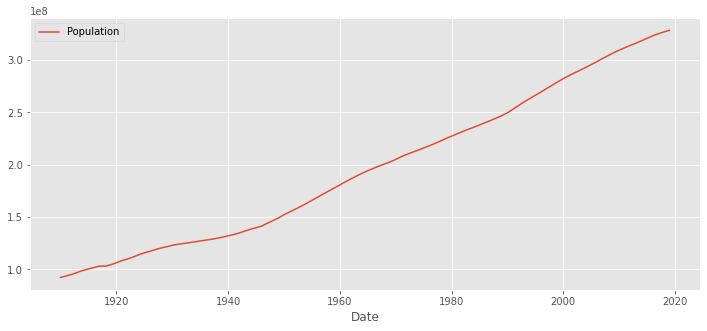

In [7]:
data = pd.read_html('https://www.multpl.com/united-states-population/table/by-year')
p = data[0]
pop = p.iloc[2:112]

pop['Date'] = pop['Date'].map(lambda x: x[6:])
pop['Value Value'] = pop['Value Value'].map(lambda x: int(float(x[:6]) * 1000000))

pop_df = pop.rename(columns={'Value Value':'Population'})
pop_df = pop_df.sort_values(by='Date').set_index('Date')
pop_df.index = pop_df.index.astype(int)

pop_df.plot()

#### 6. Total births by sex and year
To compare population growth and births in US, we have to get total births from our SSA dataset. Lets make it more descriptive and split births by sex.

In [8]:
total_births = names.pivot_table('births', index='year',
                                 columns='sex', aggfunc=sum)
total_births.tail()

sex,F,M
year,,
2015,1457416,1676595
2016,1445267,1653511
2017,1403989,1604609
2018,1380382,1568678
2019,1353716,1538056


<AxesSubplot:title={'center':'Total births by sex and year.'}, xlabel='year'>

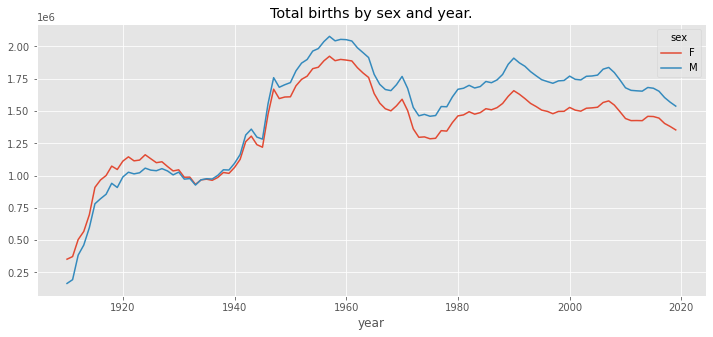

In [9]:
total_births.plot(title='Total births by sex and year.')

#### 7. Normalization before plotting.
To see both plots (SSA total names and US total population) at the same scale and be able to draw any conclusions, we have to normalize both sets of data.  

From the below graph we can see that after ending of "Baby Boom" approximately in the mid 60s, births rates went down and stayed about the same from 70s until now. But total population continued its growth linearly with the same slope angle.  

From above we can conclude, that starting at 70s and up until now the percentage of foreign born people in US have been rising. 

Text(0.5, 1.0, 'Normilized Total US population and SSA registered Births by year.')

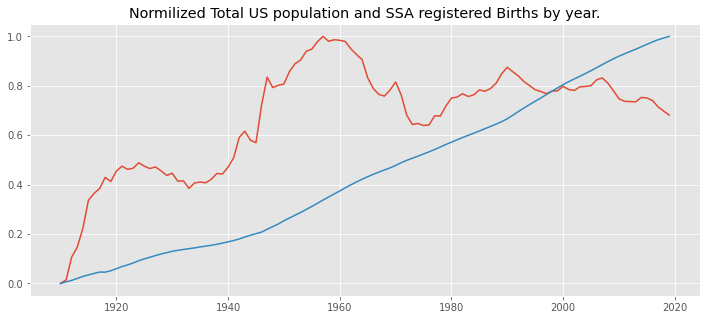

In [10]:
pop_tot =  pop_df['Population'].values.astype(float)
births_tot = (total_births['F'] + total_births['M']).values.astype(float)

min_max_scaler = preprocessing.MinMaxScaler()
pop_tot_scaled = min_max_scaler.fit_transform(pop_tot.reshape(-1, 1))
births_tot_scaled = min_max_scaler.fit_transform(births_tot.reshape(-1, 1))

pop_df['Population'] = pop_tot_scaled
total_births_all = pd.DataFrame(data=births_tot_scaled, index=total_births.index)

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.plot(total_births_all)
ax1.plot(pop_df)
ax1.set_title('Normilized Total US population and SSA registered Births by year.')

#### 8. 10 most used names in all 110 years by sex.
Now lets find out the most used names over all for both sexes. For that we'll use barplots to plot 10 most used names.    

"Mary" was still the name of the last 110 years. Being on a top probably for the laset 2 millenias, since the Christ times. Although I did not have clear data to confirm that theory :).

Text(0.5, 1.0, '10 Most used female names in US in the last 110 years.')

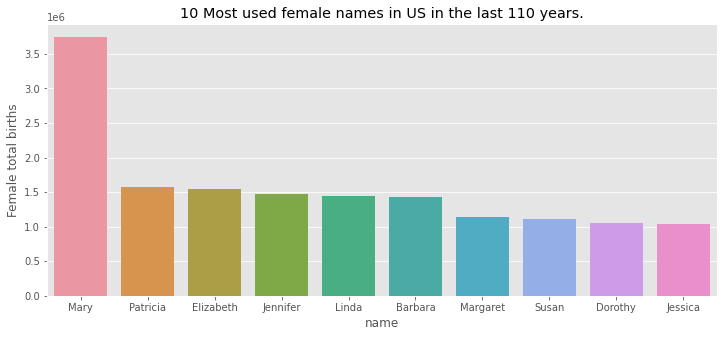

In [11]:
total_births = names.pivot_table('births', index='name',
                                 columns='sex', aggfunc=sum)
ftot = pd.DataFrame(total_births.sort_values(by='F', ascending=False)['F'].head(10))
ftot1 = ftot.rename(columns={'F':'Female total births'})

sns.barplot(x=ftot1.index,
            y='Female total births',
            data=ftot1).set_title('10 Most used female names in US in the last 110 years.')

Text(0.5, 1.0, '10 Most used male names in US in the last 110 years.')

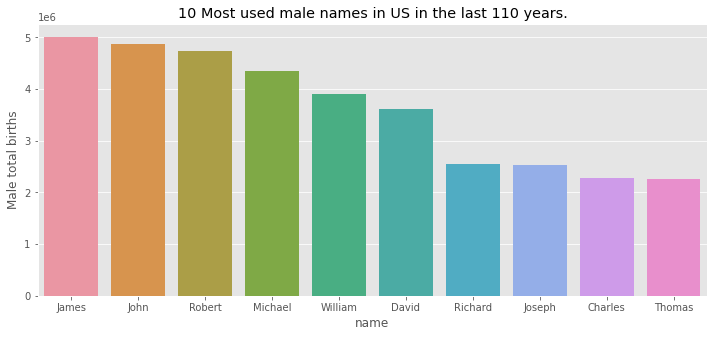

In [12]:
mtot = pd.DataFrame(total_births.sort_values(by='M', ascending=False)['M'].head(10))
mtot1 = mtot.rename(columns={'M':'Male total births'})

sns.barplot(x=mtot1.index,
            y='Male total births',
            data=mtot1).set_title('10 Most used male names in US in the last 110 years.')

#### 9. Unique names for male and female.
As expected women have about 50% more unique names over men.

In [13]:
print(str(pd.notnull(total_births.F).sum()) + ' Unique female names!' )
print(str(pd.notnull(total_births.M).sum()) + ' Unique male names!' )

21026 Unique female names!
13926 Unique male names!


#### 10. The most used name each year by sex.
We will have a table first. But since it is 110 rows long and hard to read, we will use it for determining how many years top name was on a top and in the next section we'll get to the plotting of our table. 

In [14]:
total_births = names.pivot_table('births', index=['year','name'],
                                 columns='sex', aggfunc=sum)

years = set(total_births.index.get_level_values(level=0))
top_fnames = []
top_mnames = []
for y in years:
    fmost = total_births.loc[y,'F'].sort_values(ascending=False).reset_index().iloc[0:1]
    fm = fmost.reindex(labels=[y],method='nearest')
    
    mmost = total_births.loc[y,'M'].sort_values(ascending=False).reset_index().iloc[0:1]
    mm = mmost.reindex(labels=[y],method='nearest')
    
    top_fnames.append(fm)
    top_mnames.append(mm)
    
fpop = pd.concat(top_fnames)
mpop = pd.concat(top_mnames)

all_pop = pd.merge(fpop, mpop, right_index=True, left_index=True, how='outer')
all_pop1 = all_pop.rename(columns={'name_x':'F name',
                                   'name_y':'M name',
                                   'F':'Total F births',
                                   'M':'Total M births'})
all_pop1

,F name,Total F births,M name,Total M births
1910,Mary,22848.0,John,11450.0
1911,Mary,24390.0,John,13446.0
1912,Mary,32304.0,John,24587.0
1913,Mary,36642.0,John,29329.0
1914,Mary,45345.0,John,37948.0
...,...,...,...,...
2015,Emma,20463.0,Noah,19646.0
2016,Emma,19517.0,Noah,19144.0
2017,Emma,19830.0,Liam,18821.0
2018,Emma,18757.0,Liam,19915.0


#### 11. How many years each top name was on a top.

Text(0.5, 1.0, 'Years as most popular female name.')

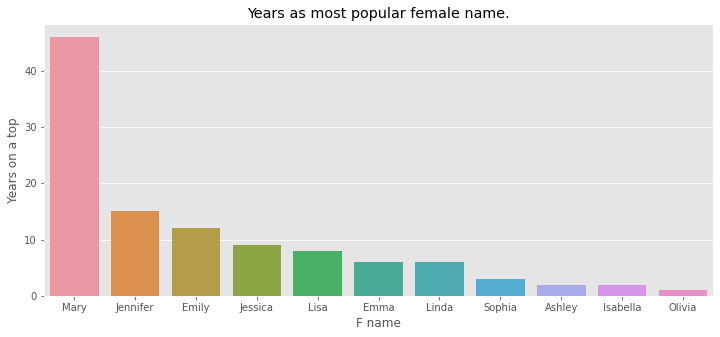

In [15]:
years_topf = all_pop1.value_counts('F name')
years_topm = all_pop1.value_counts('M name')
ytf = years_topf.reset_index().rename(columns={0:'Years on a top'})
ytm = years_topm.reset_index().rename(columns={0:'Years on a top'})

sns.barplot(x='F name',
            y='Years on a top',
            data=ytf).set_title('Years as most popular female name.')

Text(0.5, 1.0, 'Years as most popular male name.')

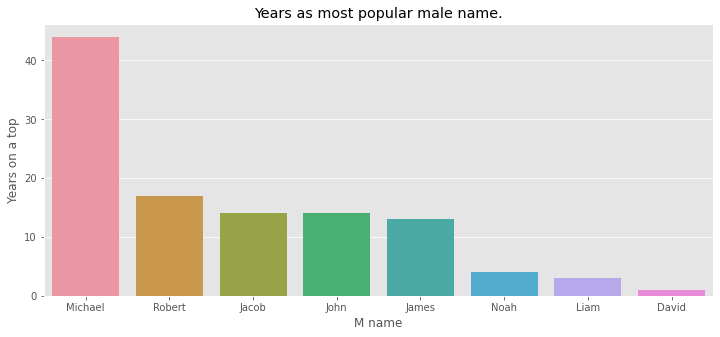

In [16]:
sns.barplot(x='M name',
            y='Years on a top',
            data=ytm).set_title('Years as most popular male name.')

#### 12. Top name for each year.
From the plots below we can see: 
1. "Mary" was dominating the top list for many years before 60s.  
* One explanation could be that in 60s-70s the culture of "Unique self" pushed people to be more "unique", look for distinction among peers and society. Which led to choosing "new" baby names.   
* In 60s also took place so called "Sexual Revolution", which chalenged not only old way of looking on sex, but old culture altogether. 

2. Name "Linda" looked like a outlier first. Until I've quick-google the posibble explanation.   
* So, in 1946 Jack Lawrence released his song with a title, yeah you've guessed it right, - "Linda". And what do you know, few years later we have Lindas running all around the place :). 

3. As for men: 
* Robert and Liam (Short from William - fresh update for modern times :) are only 2 names, which are not Biblical. In US Christianity encompasses about 70%+ of population.   
* Regarding Roberts in 1930s. As the name is old Germanic nature (however used widely around Europe), the one possible explanation may be the state of Germany after WWI and concequent migration of German nations around the globe and ofcourse to US. 

Text(0.5, 1.0, 'Female top name for each year.')

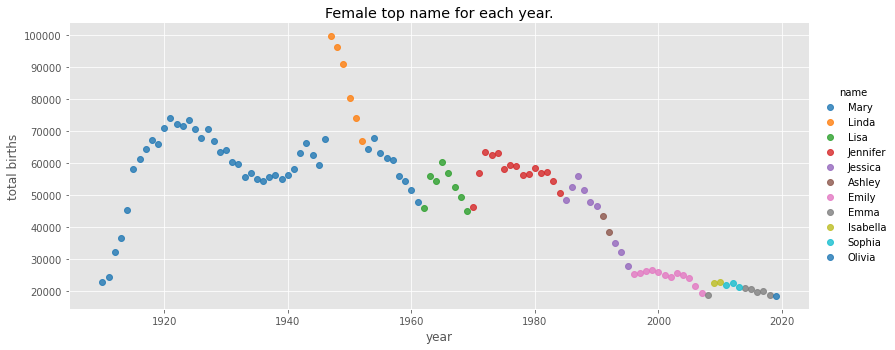

In [17]:
fpop1 = fpop.reset_index().rename(columns={'index':'year',
                                           'F':'total births'})

sns.lmplot(x='year', y='total births', data=fpop1,
           fit_reg=False,
           hue='name',
           palette='tab10',
           height=4.5,
           aspect=2.5
           )
plt.title('Female top name for each year.')

Text(0.5, 1.0, 'Male top name for each year.')

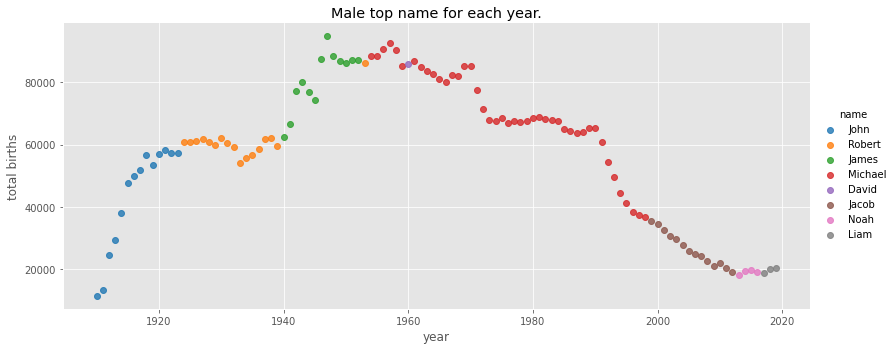

In [18]:
mpop1 = mpop.reset_index().rename(columns={'index':'year',
                                           'M':'total births'})

sns.lmplot(x='year', y='total births', data=mpop1,
           fit_reg=False,
           hue='name',
           palette='tab10',
           height=4.5,
           aspect=2.5
           )
plt.title('Male top name for each year.')

#### 13. Number of distinct names over years.
Number of unique names went up for the most part of the century starting with female names in 1940s. And male names in 1960s. 

However in a last decade we can see flatning results. Did we reach the number of possible well-sounded names ? Who knows, maybe we need some kind of cultural shake up, like in 1960s :). 

<AxesSubplot:>

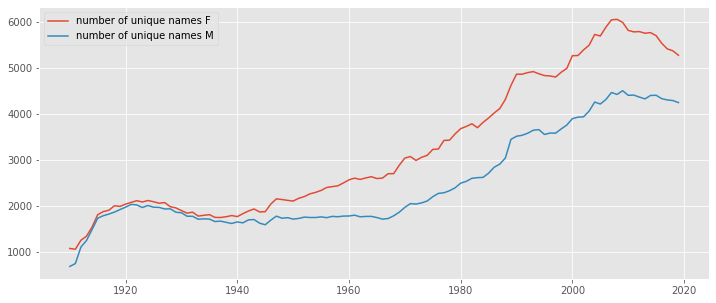

In [19]:
total_births = names.pivot_table('births', index=['year','name'],
                                 columns='sex', aggfunc=sum)
years = set(total_births.index.get_level_values(level=0))
dif_names_f = [total_births.loc[y].F.dropna().size for y in years]
dif_names_m = [total_births.loc[y].M.dropna().size for y in years]

names_f = pd.DataFrame(dif_names_f, index=years, columns=['number of unique names F'])
names_m = pd.DataFrame(dif_names_m, index=years, columns=['number of unique names M'])

names_all = pd.merge(names_f, names_m, left_index=True, right_index=True, how='outer')
names_all.plot()

#### 14. Longest and Shortest names.

In [20]:
names['name lenght'] = names['name'].map(lambda x: len(x))

longest = names.loc[names['name lenght'] == names['name lenght'].max()]
print('These are the longest names: ' + str(longest.name.unique()))

shortest = names.loc[names['name lenght'] == names['name lenght'].min()]
print('These are the shortest names: ' + str(shortest.name.unique()))

These are the longest names: ['Mariadelosangel' 'Franciscojavier' 'Ryanchristopher' 'Johnchristopher']
These are the shortest names: ['Jo' 'Ty' 'Ed' 'Al' 'Jc' 'Bo' 'La' 'Bg' 'Jd' 'De' 'Bb' 'Mc' 'No' 'Zo'
 'Jr' 'Tj' 'Cy' 'Aj' 'Lu' 'An' 'Ha' 'My' 'Ji' 'Mi' 'Vi' 'Ai' 'Pa' 'Ly'
 'Le' 'Ma' 'Vy' 'Ka' 'Tu' 'Yu' 'Kc' 'Ia' 'Na' 'Io' 'Wm' 'Vu' 'Bj' 'Va'
 'Rj' 'Ky' 'Cj' 'Ku' 'Lo' 'Ge' 'Wa' 'Dj' 'Ab' 'Oz' 'Om' 'Sy' 'Hy' 'Ej'
 'Yi' 'Jj' 'Ra' 'Ja' 'Un' 'Md' 'Eh' 'Ah' 'Mj' 'Lc' 'Yy' 'Ok' 'In' 'Ki'
 'Jb' 'Li' 'Ya' 'Zi' 'Su' 'Si' 'Yo' 'Da' 'El' 'Ho' 'Ta' 'Jt']


#### 15. Impact of alternative spelling.
To see how similar spelling impacted names count we will: 
1. Get top 10 names per each decade. 
2. Get all unique names for each decade. 
3. Compare 10 names with all names per each decade and then take top matching quartile (those matches with over 75% similarity) to represent "Alternative spelling" names. *See conclusions below computations.

In [21]:
# 1. Lets get most used names in 10 year periods for all 109 years
year_name_sex = names.pivot_table('births', index=['year','name'],
                                 columns='sex', aggfunc=sum, fill_value=0)
yns = year_name_sex.reset_index()
ybins = pd.cut(yns.year, bins = 11, precision=0) 
by_decades = yns.groupby([ybins,'name']).agg({'F':'sum','M':'sum'})
by_decades.index.names = ['decades','name']

f_dec = by_decades.F.groupby(by='decades', group_keys=False)
m_dec = by_decades.M.groupby(by='decades', group_keys=False)

top10m = m_dec.nlargest(10).reset_index(level=1).drop(columns='M')
top10m_groupped = top10m.groupby(by='decades', group_keys=False)

top10f = f_dec.nlargest(10).reset_index(level=1).drop(columns='F')
top10f_groupped = top10f.groupby(by='decades', group_keys=False)

f_dec.nlargest(10)
m_dec.nlargest(10)

decades           name     
(1910.0, 1920.0]  John         376316
                  William      303019
                  James        275071
                  Robert       239174
                  Joseph       179283
                                ...  
(2009.0, 2019.0]  Ethan        148857
                  Michael      144741
                  Alexander    141833
                  James        139307
                  Elijah       136649
Name: M, Length: 110, dtype: int64

In [22]:
# 2. Now we need all unique names for those 11 decades.
allm_groupped = by_decades.M.reset_index(level=1).drop(columns='M').groupby(by='decades',group_keys=False)
allf_groupped = by_decades.F.reset_index(level=1).drop(columns='F').groupby(by='decades',group_keys=False)

#3. Function for string comparison. Set at string similarity at 75%. 
# Returns list of mini DFs for top 10 names vs all names at each decade with value = similarity ratio. 
def find_similar_str(groupped1,groupped2):
    count = 1
    start = datetime.now()
    comparison_frames = []
    for key1, group1 in groupped1:
        for key2, group2 in groupped2:
            if key1 == key2:
                print('Working on '+ str(key1))
                print('Counter and time passed: '+str(count)+' : '+str(datetime.now() - start))
                count+=1
                for name1 in group1.name:
                    for name2 in group2.name:
                        s = SequenceMatcher(None, name1, name2)
                        if s.ratio() >= 0.75:
                            index = pd.MultiIndex.from_tuples([(key1,name2)], names=["decade", "name"])
                            frame = pd.DataFrame(data=s.ratio(), index=index, columns=[name1])
                            comparison_frames.append(frame)
    return comparison_frames

In [23]:
comparison_frames_male = find_similar_str(allm_groupped, top10m_groupped)
comparison_frames_female = find_similar_str(allf_groupped, top10f_groupped)

Working on (1910.0, 1920.0]
Counter and time passed: 1 : 0:00:00.018043
Working on (1920.0, 1930.0]
Counter and time passed: 2 : 0:00:04.411003
Working on (1930.0, 1940.0]
Counter and time passed: 3 : 0:00:08.913003
Working on (1940.0, 1950.0]
Counter and time passed: 4 : 0:00:13.426003
Working on (1950.0, 1960.0]
Counter and time passed: 5 : 0:00:18.084004
Working on (1960.0, 1969.0]
Counter and time passed: 6 : 0:00:22.801284
Working on (1969.0, 1979.0]
Counter and time passed: 7 : 0:00:27.305252
Working on (1979.0, 1989.0]
Counter and time passed: 8 : 0:00:32.102249
Working on (1989.0, 1999.0]
Counter and time passed: 9 : 0:00:36.793252
Working on (1999.0, 2009.0]
Counter and time passed: 10 : 0:00:41.579250
Working on (2009.0, 2019.0]
Counter and time passed: 11 : 0:00:46.324282
Working on (1910.0, 1920.0]
Counter and time passed: 1 : 0:00:00.017999
Working on (1920.0, 1930.0]
Counter and time passed: 2 : 0:00:04.529960
Working on (1930.0, 1940.0]
Counter and time passed: 3 : 0:00:

In [24]:
#4. Now we concatenate all little comparison Dfs into 1 DF for each sex. 
all_male = pd.concat(comparison_frames_male)
all_female = pd.concat(comparison_frames_female)

In [25]:
#5. Saving to Excel for some additional review if needed. 
am = all_male.reset_index()
af = all_female.reset_index()

am.decade = am.decade.astype(str)
af.decade = af.decade.astype(str)

am2 = am.groupby(by=['decade','name']).mean()
am2.to_excel('all_male_correlatins.xlsx')

af2 = af.groupby(by=['decade','name']).mean()
af2.to_excel('all_female_correlatins.xlsx')

In [26]:
#6. Unique similarly spelled names per decade for Males andm Females.
total_f = []
decades = sorted(set(af2.index.get_level_values(0)))
for x in decades:
    print('In '+str(x) +' there were: ' + str(np.sum(af2.loc[x].sum() > 0)) +
          ' Female names similarly spelled to the top 10 names at that decade!')
    total_f.append(np.sum(af2.loc[x].sum() > 0))     

plot_frame_f = pd.DataFrame(total_f, index=decades,  columns=['Similar Female names'])
new_index = [x[1:5]+'-'+x[9:13] for x in plot_frame_f.index.values]
plot_frame_f.index = new_index
plot_frame_f.index.name = 'Decades'

In (1910.0, 1920.0] there were: 247 Female names similarly spelled to the top 10 names at that decade!
In (1920.0, 1930.0] there were: 207 Female names similarly spelled to the top 10 names at that decade!
In (1930.0, 1940.0] there were: 273 Female names similarly spelled to the top 10 names at that decade!
In (1940.0, 1950.0] there were: 328 Female names similarly spelled to the top 10 names at that decade!
In (1950.0, 1960.0] there were: 291 Female names similarly spelled to the top 10 names at that decade!
In (1960.0, 1969.0] there were: 394 Female names similarly spelled to the top 10 names at that decade!
In (1969.0, 1979.0] there were: 385 Female names similarly spelled to the top 10 names at that decade!
In (1979.0, 1989.0] there were: 320 Female names similarly spelled to the top 10 names at that decade!
In (1989.0, 1999.0] there were: 299 Female names similarly spelled to the top 10 names at that decade!
In (1999.0, 2009.0] there were: 235 Female names similarly spelled to the

In [27]:
total_m = []
decades = sorted(set(am2.index.get_level_values(0)))
for x in decades:
    print('In '+str(x) +' there were: ' + str(np.sum(am2.loc[x].sum() > 0)) +
          ' Male names similarly spelled to the top 10 names at that decade!')
    total_m.append(np.sum(am2.loc[x].sum() > 0))
    
plot_frame_m = pd.DataFrame(total_m, index=decades,  columns=['Similar Male names'])
new_index = [x[1:5]+'-'+x[9:13] for x in plot_frame_m.index.values]
plot_frame_m.index = new_index
plot_frame_m.index.name = 'Decades'

In (1910.0, 1920.0] there were: 230 Male names similarly spelled to the top 10 names at that decade!
In (1920.0, 1930.0] there were: 232 Male names similarly spelled to the top 10 names at that decade!
In (1930.0, 1940.0] there were: 234 Male names similarly spelled to the top 10 names at that decade!
In (1940.0, 1950.0] there were: 288 Male names similarly spelled to the top 10 names at that decade!
In (1950.0, 1960.0] there were: 305 Male names similarly spelled to the top 10 names at that decade!
In (1960.0, 1969.0] there were: 259 Male names similarly spelled to the top 10 names at that decade!
In (1969.0, 1979.0] there were: 332 Male names similarly spelled to the top 10 names at that decade!
In (1979.0, 1989.0] there were: 320 Male names similarly spelled to the top 10 names at that decade!
In (1989.0, 1999.0] there were: 313 Male names similarly spelled to the top 10 names at that decade!
In (1999.0, 2009.0] there were: 299 Male names similarly spelled to the top 10 names at tha

Text(0.5, 1.0, 'Use of alternatively spelled names over decades.')

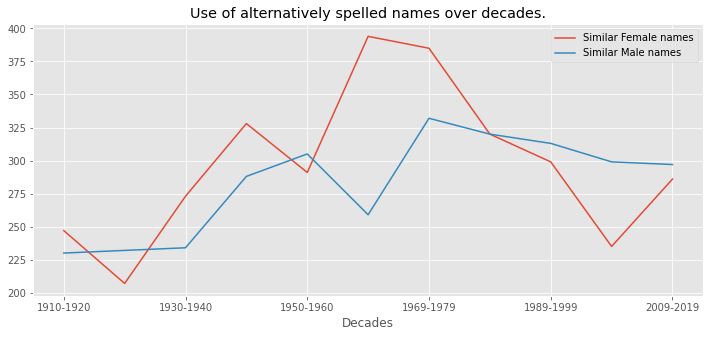

In [28]:
total_smilat_to_plt = pd.merge( plot_frame_f, plot_frame_m, left_index=True, right_index=True)
total_smilat_to_plt.plot().set_title('Use of alternatively spelled names over decades.')

In [29]:
# 7 How many unique closely spelled names we have over 110 years in both groups (M and F) 
# and compare it to the use of alternative spelled names over decades to see paterns in name usage. 
print('Total use of alternatively spelled names over decades for Females: ' + str(sum(total_f)))
print('Total use of alternatively spelled names over decades for Males: ' + str(sum(total_m)))
print('Total unique alternatively spelled names in 110 years period for Males: '+ str(am2.columns.size))
print('Total unique alternatively spelled names in 110 years period for Females: '+ str(af2.columns.size))

Total use of alternatively spelled names over decades for Females: 3265
Total use of alternatively spelled names over decades for Males: 3109
Total unique alternatively spelled names in 110 years period for Males: 903
Total unique alternatively spelled names in 110 years period for Females: 1715


 From this observation we can conclude :
 1. Males and females similar names were used at about the same rate over decades 
 ( 3265 names for Females and 3109 names for Males). See picture above for numbers by decades.
 2. However the male names are reused in subsequent decades more often,tnan Female names. As we have 
 903 unique similar names used for Males over period of 110 years. When for Females we have 
 1715 unique similar names used for 110 years. 

#### 16. Use of ethnic names over the years.
Here we will gather most common names for 3 ethnic groups: Russian, Italian, Latino. And check how often over the period of 110 years those names were used.

In [30]:
# 1. Scrape most used ethnic names for : Russin, Italian,  and Latino groups.
russian = pd.read_html('https://www.thoughtco.com/common-russian-names-4770041')
russian_male = russian[1]
russian_female = russian[0]

In [31]:
russian_m = russian_male.iloc[1:,0:1]
russian_m.at[2,0]  = russian_m.at[2,0][0:9]
russian_m.at[6,0] = russian_m.at[6,0][0:6]
russian_m.columns = ['M']
russian_m.reset_index(drop=True, inplace=True)

In [32]:
#2. Fixing misspelling and messy data.
russian_f = russian_female.iloc[:,0:1]
russian_f.iat[3,0] = russian_f.iat[3,0][0:6]
russian_f.iat[5,0] = russian_f.iat[5,0][0:10]
russian_f.iat[8,0] = russian_f.iat[8,0][-5:]
russian_f.iat[17,0] = russian_f.iat[17,0][-9:]
russian_f.iat[22,0] = russian_f.iat[22,0][-9:]
russian_f.columns = ['F']

In [33]:
all_ru = pd.concat([russian_f, russian_m], axis=1)

all_rus = all_ru['M'].tolist() + all_ru['F'].tolist()
all_rus

['Artyom',
 'Aleksandr',
 'Roman',
 'Yevgeny',
 'Ivan',
 'Maksim',
 'Denis',
 'Alexey',
 'Dmitry',
 'Danyl',
 'Sergey',
 'Nikolai',
 'Konstantin',
 'Nikita',
 'Mikhail',
 'Boris',
 'Victor',
 'Gennady',
 'Vyacheslav',
 'Vladimir',
 'Andrey',
 'Anatoly',
 'Ilya',
 'Kirill',
 'Oleg',
 'Sofia',
 'Anastasia',
 'Victoria',
 'Ksenia',
 'Arina',
 'Yelizaveta',
 'Adelina',
 'Irina',
 'Elena',
 'Polina',
 'Daria',
 'Natalia',
 'Svetlana',
 'Vera',
 'Nadezhda',
 'Galina',
 'Lyubov',
 'Alexandra',
 'Maria',
 'Anna',
 'Angelina',
 'Marina',
 'Ekaterina',
 'Ludmila',
 'Tatiana']

In [34]:
# 3. Now the same for latino names
latino = pd.read_html('https://www.1happybirthday.com/popular_names_latino.php')

In [35]:
all_latino = latino[0]
latino_temp = all_latino.drop(columns='Rank').iloc[:25]
latino_temp.at[0,'Male Name'] = 'Jose'
latino_temp.at[6,'Male Name'] = 'Jesus'
latino_temp.at[9,'Male Name'] = 'Sebastian'
latino_temp.at[10,'Male Name'] = 'Matias'
latino_temp.at[11,'Male Name'] = 'Emiliano'
latino_temp.at[12,'Male Name'] = 'Andres'
latino_temp.at[16,'Male Name'] = 'Felipe'
latino_temp.at[17,'Male Name'] = 'Ignacio'
latino_temp.at[18,'Male Name'] = 'Joaquin'
latino_temp.at[19,'Male Name'] = 'Francisco'
latino_temp.at[22,'Male Name'] = 'Rodrigo'

latino_temp.at[0,'Female Name'] = 'Sofia'
latino_temp.at[7,'Female Name'] = 'Antonella'
latino_temp.at[9,'Female Name'] = 'Emilia'
latino_temp.at[14,'Female Name'] = 'Paula'
latino_temp.at[15,'Female Name'] = 'Lucia'
latino_temp.at[16,'Female Name'] = 'Alessandra'
latino_temp.at[18,'Female Name'] = 'Mia'
latino_temp.at[23,'Female Name'] = 'Juana'

all_lat = latino_temp['Male Name'].tolist() + latino_temp['Female Name'].tolist()
all_lat

['Jose',
 'Luis',
 'Carlos',
 'Juan',
 'Jorge',
 'Pedro',
 'Jesus',
 'Manuel',
 'Santiago',
 'Sebastian',
 'Matias',
 'Emiliano',
 'Andres',
 'Alejandro',
 'Mateo',
 'Diego',
 'Felipe',
 'Ignacio',
 'Joaquin',
 'Francisco',
 'Gabriel',
 'Lucas',
 'Rodrigo',
 'Emmanuel',
 'Alexander',
 'Sofia',
 'Valentina',
 'Isabella',
 'Camila',
 'Valeria',
 'Mariana',
 'Gabriela',
 'Antonella',
 'Daniella',
 'Emilia',
 'Victoria',
 'Martina',
 'Luciana',
 'Ximena',
 'Paula',
 'Lucia',
 'Alessandra',
 'Catalina',
 'Mia',
 'Fernanda',
 'Nicole',
 'Julieta',
 'Abril',
 'Juana',
 'Andrea']

In [36]:
# 4. Now for Italian
italian = pd.read_html('https://www.italianames.com/most-common-italian-names.php')

In [37]:
all_italian = italian[0].drop(columns='Unnamed: 0')
all_it = all_italian['Adult Males'].tolist() + all_italian['Adult Females'].tolist()
all_it

['Giuseppe',
 'Giovanni',
 'Antonio',
 'Mario',
 'Luigi',
 'Francesco',
 'Angelo',
 'Vincenzo',
 'Pietro',
 'Salvatore',
 'Carlo',
 'Franco',
 'Domenico',
 'Bruno',
 'Paolo',
 'Michele',
 'Giorgio',
 'Aldo',
 'Sergio',
 'Luciano',
 'Maria',
 'Anna',
 'Giuseppina',
 'Rosa',
 'Angela',
 'Giovanna',
 'Teresa',
 'Lucia',
 'Carmela',
 'Caterina',
 'Francesca',
 'Anna Maria',
 'Antonietta',
 'Carla',
 'Elena',
 'Concetta',
 'Rita',
 'Margherita',
 'Franca',
 'Paola']

In [38]:
# 5. Now get all names by year
names_by_year = names.groupby(by=['year','name']).sum().drop(columns='name lenght')
names_by_year

births
year name           
1910 Aaron       111
     Abbie        28
     Abe          31
     Abner        12
     Abraham     138
...              ...
2019 Zymere        5
     Zymir        55
     Zyon        171
     Zyra         16
     Zyrah         6

[594681 rows x 1 columns]

In [39]:
# 6. Function will compare ethnic names to all names given at that year and 
# return number of births every year with ethnic names. 
def get_ethnic(ethnic_group_names, names_by_year):
    births_by_year = {}
    for year in years:
        for n in names_by_year.loc[year].index:
            for n2 in ethnic_group_names:
                if n == n2:
                    births = names_by_year.loc[year].loc[n].births
                    births_by_year[year] = births
    return births_by_year

In [40]:
latino_by_year = get_ethnic(all_lat, names_by_year)

In [41]:
russian_by_year = get_ethnic(all_rus, names_by_year)

In [42]:
italian_by_year = get_ethnic(all_it, names_by_year)

In [43]:
# 7. Placing it all togeather. p_italian,p_russian,p_latino - are percenrages of ethnic groups 
# related to Total births at that year.
ethnic_tot = pd.DataFrame([italian_by_year,russian_by_year,latino_by_year],
                           index=['Italian','Russian','Latino'])
ethnic_t = ethnic_tot.T
et = ethnic_t.assign(Total_births = [int(x) for x in births_tot])
et_per = et.assign(p_italian = et.Italian / et.Total_births,
                   p_russian = et.Russian / et.Total_births,
                   p_latino = et.Latino / et.Total_births)
et_per.index.name = 'year'
et_per.reset_index(inplace=True)
et_per

,year,Italian,Russian,Latino,Total_births,p_italian,p_russian,p_latino
0,1910,160,532,532,516313,0.000310,0.001030,0.001030
1,1911,15,459,459,565817,0.000027,0.000811,0.000811
2,1912,14,673,673,888002,0.000016,0.000758,0.000758
3,1913,26,785,785,1028578,0.000025,0.000763,0.000763
4,1914,36,995,995,1293348,0.000028,0.000769,0.000769
...,...,...,...,...,...,...,...,...
105,2015,229,112,2575,3134011,0.000073,0.000036,0.000822
106,2016,256,129,2665,3098778,0.000083,0.000042,0.000860
107,2017,218,100,2515,3008598,0.000072,0.000033,0.000836
108,2018,269,102,2553,2949060,0.000091,0.000035,0.000866


In [44]:
# Now lets calculate moving average for all 3 groups to have  smoother plot, 
# as some years have very few births.
et_per.drop(columns=['Italian','Russian','Latino','Total_births'],inplace=True)

In [45]:
et_per['p_italian'] = et_per['p_italian'].ewm(span=10).mean()
et_per['p_russian'] = et_per['p_russian'].ewm(span=10).mean()
et_per['p_latino'] = et_per['p_latino'].ewm(span=10).mean()
et_per

,year,p_italian,p_russian,p_latino
0,1910,0.000310,0.001030,0.001030
1,1911,0.000154,0.000910,0.000910
2,1912,0.000098,0.000849,0.000849
3,1913,0.000074,0.000821,0.000821
4,1914,0.000061,0.000806,0.000806
...,...,...,...,...
105,2015,0.000067,0.000033,0.000514
106,2016,0.000070,0.000034,0.000577
107,2017,0.000070,0.000034,0.000624
108,2018,0.000074,0.000034,0.000668


In [46]:
#8. Melting a column to use it as hue in sns plotting. 
et_per_melted = et_per.melt(id_vars='year',var_name='ethnic group',value_name='births')
et_per_melted.rename(columns={'births':'births percentage'}, inplace=True)

Text(0.5, 1.0, 'Ethnic population names over years as percentage of total population.')

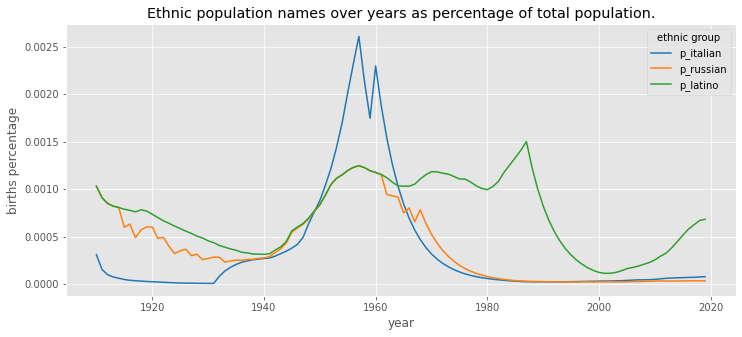

In [47]:
sns.lineplot(x='year', y='births percentage', data=et_per_melted,
           hue='ethnic group',
           palette='tab10'
           )
plt.title('Ethnic population names over years as percentage of total population.')